## Imports

In [1]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

## Get filenames

In [2]:
# Get files in data path
path='BirdSound/'
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 450 audio files in BirdSound/


## Prepare labels from filenames

In [3]:
labels =[]
classes=['Avocet','Bee_eater','Bittern','Bulbul','Bushshrike','Bush_warbler','Cisticola','Coot','Cormorant',
         'Crake','Crane', 'Cuckooshrike', 'Dove','Drongo','Eagle','Egret','Falcon','Gallinule', 'Grassbird', 
         'Grebe','Grouse','Gull','Hawk','Heron','Hornbill' ,'Jay' ,'Kingfisher','Kite','Lapwing', 'Lark', 
         'Leaf_warbler','Martin','Nightjar','Oystercatcher', 'Parrot', 'Pheasant','Pigeon', 'Pipit',  
         'Pitta','Plover','Quail','Rail','Raven','Reed_warbler','Roller','Sandpiper','Sparrow','Starling' , 
         'Stilt', 'Sunbird', 'Swift','Treecreeper','Trogon','Turaco', 'Wagtail','Waxbill','Weaver',
         'White_eye','Woodpecker']



color_dict={
    
           'Avocet':'blue','Bee_eater':'red','Bittern':'green','Bulbul':'black','Bushshrike':'magenta',
         'Bush_warbler':'magenta','Cisticola':'magenta','Coot':'magenta','Cormorant':'magenta',
         'Crake':'magenta','Crane':'magenta', 'Cuckooshrike':'magenta', 'Dove':'magenta','Drongo':'magenta',
         'Eagle':'magenta','Egret':'magenta','Falcon':'magenta','Gallinule':'magenta', 'Grassbird':'magenta', 
         'Grebe':'magenta','Grouse':'magenta','Gull':'magenta','Hawk':'magenta','Heron':'magenta',
         'Hornbill':'magenta' ,'Jay':'magenta' ,'Kingfisher':'magenta','Kite':'magenta','Lapwing':'magenta', 
         'Lark':'magenta','Leaf_warbler':'magenta','Martin':'magenta',   'Nightjar':'magenta',
         'Oystercatcher':'magenta', 'Parrot':'magenta', 'Pheasant':'magenta','Pigeon':'magenta', 
         'Pipit':'magenta','Pitta':'magenta','Plover':'magenta','Quail':'magenta','Rail':'magenta',
         'Raven':'magenta','Reed_warbler':'magenta','Roller':'magenta','Sandpiper':'magenta',
         'Sparrow':'magenta','Starling':'magenta' ,'Stilt':'magenta', 'Sunbird':'magenta', 'Swift':'magenta','Treecreeper':'magenta',
         'Trogon':'magenta','Turaco':'magenta', 'Wagtail':'magenta','Waxbill':'magenta','Weaver':'magenta',
         'White_eye':'magenta','Woodpecker':'magenta'
           
           }

color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [4]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

20 classes: Avocet, Coot, Crake, Crane, Dove, Gallinule, Grebe, Grouse, Lapwing, Nightjar, Oystercatcher, Pheasant, Pigeon, Plover, Quail, Rail, Sandpiper, Stilt, Swift, Turaco


## Parameters for MFCC

In [5]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Function to Calculate Audio Features: MFCC

In [6]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    #S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    #mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    melspectrogram = librosa.feature.melspectrogram(y, sr=fs)
    feature_vector = np.mean(melspectrogram,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

## Load audio files, calculate features and create feature vectors

In [7]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 450 = BirdSound/Gallinule/XC131319 - Common Gallinule - Gallinula galeata.wav
get 2 of 450 = BirdSound/Gallinule/XC465599 - Common Gallinule - Gallinula galeata cachinnans.wav
get 3 of 450 = BirdSound/Gallinule/XC452961 - Common Gallinule - Gallinula galeata.wav
get 4 of 450 = BirdSound/Gallinule/XC45353 - Spot-flanked Gallinule - Porphyriops melanops crassirostris.wav
get 5 of 450 = BirdSound/Gallinule/XC91834 - Spot-flanked Gallinule - Porphyriops melanops.wav
get 6 of 450 = BirdSound/Gallinule/XC414334 - Common Gallinule - Gallinula galeata.wav
get 7 of 450 = BirdSound/Gallinule/XC368531 - Common Gallinule - Gallinula galeata.wav
get 8 of 450 = BirdSound/Gallinule/XC37123 - Purple Gallinule - Porphyrio martinica.wav
get 9 of 450 = BirdSound/Gallinule/XC7979 - Common Gallinule - Gallinula galeata.wav
get 10 of 450 = BirdSound/Gallinule/XC246282 - Common Gallinule - Gallinula galeata.wav
get 11 of 450 = BirdSound/Gallinule/XC384693 - Common Gallinule - Gallinula galeata.wav
g

get 95 of 450 = BirdSound/Crane/XC216976 - Common Crane - Grus grus.wav
get 96 of 450 = BirdSound/Crake/XC364028 - Rufous-faced Crake - Laterallus xenopterus.wav
get 97 of 450 = BirdSound/Crake/XC15483 - Rufous-faced Crake - Laterallus xenopterus.wav
get 98 of 450 = BirdSound/Crake/XC270595 - Chestnut-headed Crake - Anurolimnas castaneiceps.wav
get 99 of 450 = BirdSound/Crake/XC237988 - Chestnut-headed Crake - Anurolimnas castaneiceps castaneiceps.wav
get 100 of 450 = BirdSound/Crake/XC13469 - Black-banded Crake - Laterallus fasciatus~1.wav
get 101 of 450 = BirdSound/Crake/XC224864 - Rusty-flanked Crake - Laterallus levraudi.wav
get 102 of 450 = BirdSound/Crake/XC69265 - Spotless Crake - Porzana tabuensis.wav
get 103 of 450 = BirdSound/Crake/XC288426 - Grey-breasted Crake - Laterallus exilis.wav
get 104 of 450 = BirdSound/Crake/XC218852 - Russet-crowned Crake - Laterallus viridis.wav
get 105 of 450 = BirdSound/Crake/XC13469 - Black-banded Crake - Laterallus fasciatus.wav
get 106 of 450

get 187 of 450 = BirdSound/Dove/XC17077 - Ruddy Ground Dove - Columbina talpacoti.wav
get 188 of 450 = BirdSound/Dove/XC74980 - Common Ground Dove - Columbina passerina.wav
get 189 of 450 = BirdSound/Dove/XC300695 - Ring-necked Dove - Streptopelia capicola somalica.wav
get 190 of 450 = BirdSound/Dove/XC209306 - Blue Ground Dove - Claravis pretiosa.wav
get 191 of 450 = BirdSound/Coot/XC14381 - American Coot - Fulica americana~1.wav
get 192 of 450 = BirdSound/Coot/XC287245 - Andean Coot - Fulica ardesiaca.wav
get 193 of 450 = BirdSound/Coot/XC139909 - American Coot - Fulica americana.wav
get 194 of 450 = BirdSound/Coot/XC48557 - Red-fronted Coot - Fulica rufifrons.wav
get 195 of 450 = BirdSound/Coot/XC175423 - Eurasian Coot - Fulica atra.wav
get 196 of 450 = BirdSound/Coot/XC57425 - American Coot - Fulica americana.wav
get 197 of 450 = BirdSound/Coot/XC160661 - American Coot - Fulica americana.wav
get 198 of 450 = BirdSound/Coot/XC37846 - American Coot - Fulica americana.wav
get 199 of 4

get 284 of 450 = BirdSound/Plover/XC140325 - Little Ringed Plover - Charadrius dubius papuanus.wav
get 285 of 450 = BirdSound/Plover/XC59911 - Rufous-chested Plover - Charadrius modestus.wav
get 286 of 450 = BirdSound/Plover/XC371003 - Kentish Plover - Charadrius alexandrinus.wav
get 287 of 450 = BirdSound/Plover/XC309206 - Little Ringed Plover - Charadrius dubius curonicus.wav
get 288 of 450 = BirdSound/Plover/XC356536 - Common Ringed Plover - Charadrius hiaticula.wav
get 289 of 450 = BirdSound/Plover/XC345511 - European Golden Plover - Pluvialis apricaria.wav
get 290 of 450 = BirdSound/Plover/XC51732 - Collared Plover - Charadrius collaris.wav
get 291 of 450 = BirdSound/Plover/XC339475 - Common Ringed Plover - Charadrius hiaticula.wav
get 292 of 450 = BirdSound/Plover/XC378002 - Common Ringed Plover - Charadrius hiaticula.wav
get 293 of 450 = BirdSound/Plover/XC441251 - Grey Plover - Pluvialis squatarola.wav
get 294 of 450 = BirdSound/Plover/XC266278 - Little Ringed Plover - Charadri

get 370 of 450 = BirdSound/Oystercatcher/XC144971 - Eurasian Oystercatcher - Haematopus ostralegus.wav
get 371 of 450 = BirdSound/Pigeon/XC715 - Ruddy Pigeon - Patagioenas subvinacea.wav
get 372 of 450 = BirdSound/Pigeon/XC368234 - Dusky Pigeon - Patagioenas goodsoni.wav
get 373 of 450 = BirdSound/Pigeon/XC221376 - Short-billed Pigeon - Patagioenas nigrirostris.wav
get 374 of 450 = BirdSound/Pigeon/XC205976 - Picazuro Pigeon - Patagioenas picazuro.wav
get 375 of 450 = BirdSound/Pigeon/XC94615 - Common Wood Pigeon - Columba palumbus.wav
get 376 of 450 = BirdSound/Pigeon/XC246531 - White-bellied Green Pigeon - Treron sieboldii.wav
get 377 of 450 = BirdSound/Pigeon/XC39584 - Ruddy Pigeon - Patagioenas subvinacea.wav
get 378 of 450 = BirdSound/Pigeon/XC166060 - Orange-breasted Green Pigeon - Treron bicinctus.wav
get 379 of 450 = BirdSound/Pigeon/XC271973 - Plumbeous Pigeon - Patagioenas plumbea wallacei.wav
get 380 of 450 = BirdSound/Pigeon/XC257603 - Plumbeous Pigeon - Patagioenas plumbea

## Standardization: Zero-Mean and Unit-Variance

In [8]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (450, 128)


## Train and Test Sets

In [9]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [10]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (337, 128)
test_set shape: (113, 128)
train_classes shape: (337,)
test_classes shape: (113,)


## 1.kNN Classification

In [11]:
# KNN Classifier
n_neighbors=1
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [12]:
# kNN
model_knn.fit(train_set, train_classes);

In [13]:
# Predict using the Test Set
predicted_labels = model_knn.predict(test_set)

## Evaluation

In [14]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.5        0.33333333 0.14285714 0.66666667 0.28571429 0.
 0.14285714 0.         0.16666667 0.         0.2        0.
 0.         0.         0.2        0.2        0.2        0.
 0.2        0.6       ]
Precision:  [0.5        0.18181818 0.125      0.8        0.28571429 0.
 0.09090909 0.         0.25       0.         0.5        0.
 0.         0.         0.125      0.25       0.25       0.
 0.25       0.375     ]
F1-Score:  [0.5        0.23529412 0.13333333 0.72727273 0.28571429 0.
 0.11111111 0.         0.2        0.         0.28571429 0.
 0.         0.         0.15384615 0.22222222 0.22222222 0.
 0.22222222 0.46153846]
Accuracy: 0.19  , 22
Number of samples: 113


In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [16]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

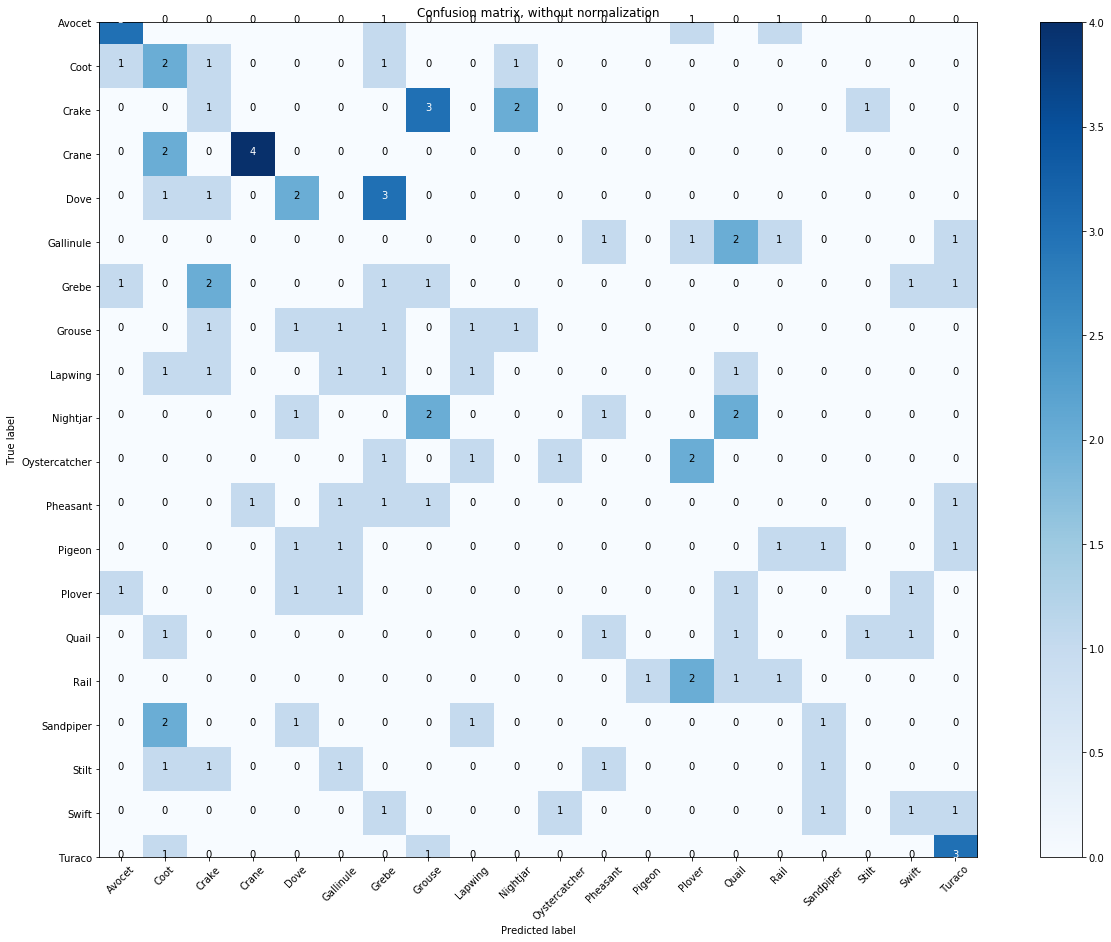

In [17]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [18]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [19]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['Grebe' 'Grouse' 'Dove' 'Avocet' 'Coot' 'Nightjar' 'Lapwing' 'Lapwing'
 'Rail' 'Nightjar' 'Crake' 'Nightjar' 'Quail' 'Lapwing' 'Crane' 'Grebe'
 'Grebe' 'Grebe' 'Quail' 'Stilt' 'Pheasant' 'Quail' 'Turaco' 'Crane'
 'Pheasant' 'Grebe' 'Dove' 'Plover' 'Oystercatcher' 'Pheasant' 'Pigeon'
 'Swift' 'Avocet' 'Stilt' 'Stilt' 'Gallinule' 'Coot' 'Grebe' 'Swift'
 'Grouse' 'Crake' 'Pheasant' 'Gallinule' 'Pigeon' 'Grouse' 'Sandpiper'
 'Gallinule' 'Sandpiper' 'Gallinule' 'Sandpiper' 'Oystercatcher' 'Crake'
 'Pheasant' 'Grouse' 'Oystercatcher' 'Grouse' 'Dove' 'Dove' 'Plover'
 'Plover' 'Gallinule' 'Rail' 'Coot' 'Nightjar' 'Crake' 'Grouse' 'Turaco'
 'Lapwing' 'Pigeon' 'Crake' 'Oystercatcher' 'Nightjar' 'Avocet' 'Pigeon'
 'Plover' 'Swift' 'Plover' 'Lapwing' 'Coot' 'Stilt' 'Pigeon' 'Rail'
 'Stilt' 'Quail' 'Gallinule' 'Swift' 'Rail' 'Dove' 'Sandpiper' 'Crake'
 'Nightjar']
[ 7  2  2 15  2 11  6  1 14 14 17 14 11 14  1  2  0  2  1  5  3 17  1  1
 19 18  6 18 13  7 15 19  6  2 16 14  6 19 10  4  7  5 19  5  

## 2. Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
model_Logistic = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

In [22]:
model_Logistic.fit(train_set, train_classes);

## Save / Load Trained Model

In [24]:
# Save
#joblib.dump(model_Logistic, 'Mfcc_trainedLogisticRegression.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [25]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_Logistic.predict(test_set)

## Evaluation

In [27]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.5  0.67 0.14 0.83 0.29 0.33 0.14 0.   0.5  0.33 0.8  0.6  0.   0.
 0.   0.2  0.   0.   0.6  0.2 ]
Precision:  [1.   0.22 0.2  0.56 0.29 0.4  0.14 0.   0.6  0.25 0.57 0.3  0.   0.
 0.   0.5  0.   0.   0.38 0.5 ]
F1-Score:  [0.67 0.33 0.17 0.67 0.29 0.36 0.14 0.   0.55 0.29 0.67 0.4  0.   0.
 0.   0.29 0.   0.   0.46 0.29]
Accuracy: 0.31  , 35
Number of samples: 113


In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [29]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

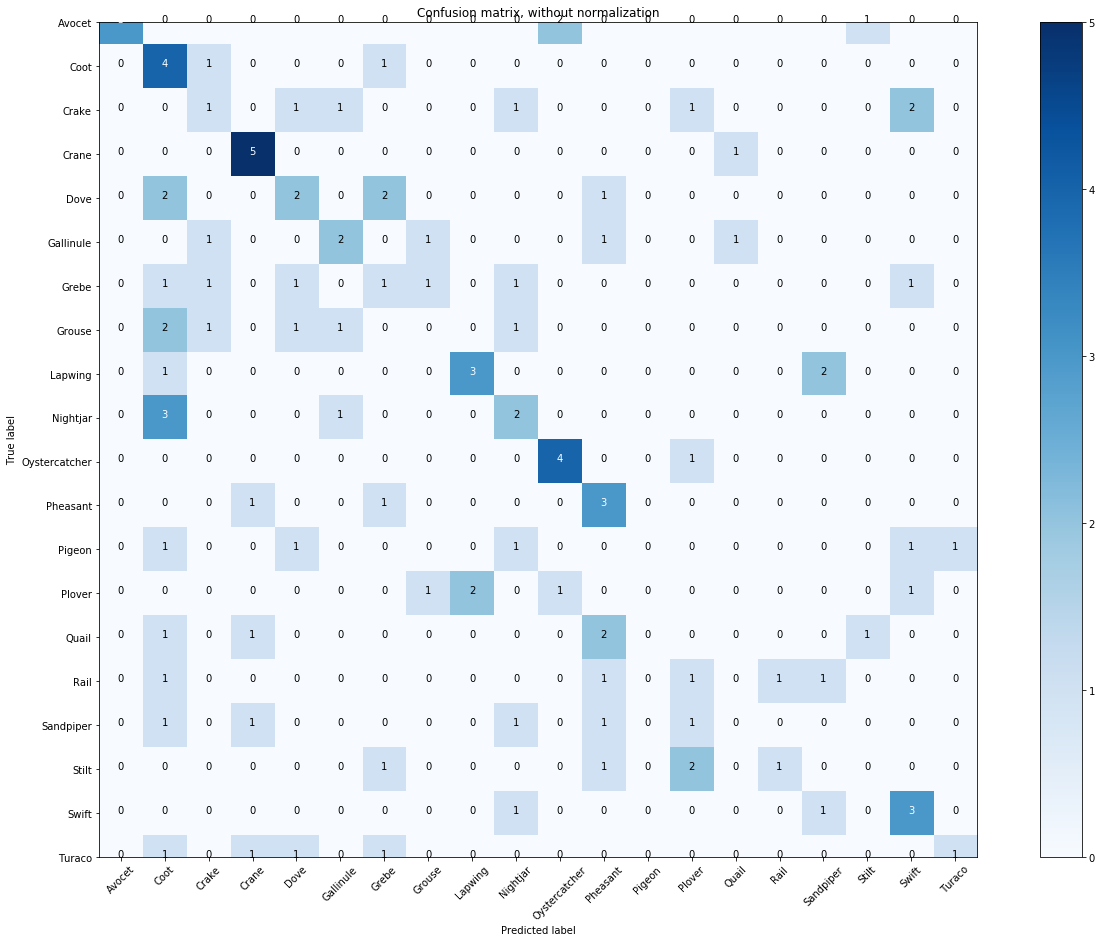

In [30]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [31]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [32]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['Grebe' 'Grouse' 'Dove' 'Sandpiper' 'Avocet' 'Nightjar' 'Lapwing'
 'Lapwing' 'Rail' 'Nightjar' 'Crake' 'Quail' 'Grebe' 'Grebe' 'Grebe'
 'Quail' 'Stilt' 'Pheasant' 'Quail' 'Turaco' 'Turaco' 'Pheasant' 'Grebe'
 'Dove' 'Plover' 'Pigeon' 'Avocet' 'Stilt' 'Stilt' 'Lapwing' 'Gallinule'
 'Coot' 'Grebe' 'Grouse' 'Crake' 'Pigeon' 'Grouse' 'Sandpiper' 'Sandpiper'
 'Gallinule' 'Sandpiper' 'Oystercatcher' 'Crake' 'Grouse' 'Grouse' 'Dove'
 'Dove' 'Turaco' 'Plover' 'Plover' 'Gallinule' 'Rail' 'Nightjar' 'Crake'
 'Grouse' 'Turaco' 'Pigeon' 'Crake' 'Nightjar' 'Avocet' 'Pigeon' 'Plover'
 'Quail' 'Swift' 'Plover' 'Coot' 'Stilt' 'Pigeon' 'Rail' 'Stilt' 'Quail'
 'Gallinule' 'Crane' 'Swift' 'Rail' 'Dove' 'Sandpiper' 'Crake']
[ 7  2  1  3 10  1 16  1 16  5 13 11  2  1  9  3 15  3 17  4  1  6 18  6
 18  9 17 13 13 16  2  6  4  4  5 19  9  9  1 14 13 13 18  5  1  6  1  3
  8  8 11  1  1  9  1  6  4  4  1 10  1  7 11  9 10  2  6 18 13 11  1  7
 14 16 11 11 11 18]
['Grouse' 'Crake' 'Coot' 'Crane' 'Oystercatche

## 3.SVM

In [34]:
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
model_svm = SVC(kernel='rbf', C = 10.0, gamma=0.1) 

/home/rutherford/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [35]:
# SVM
#model_svm.fit(train_set, train_classes);
model_svm.fit(train_set, train_classes);

## Save / Load Trained Model

In [36]:
# Save
#joblib.dump(svclassifier, 'trainedSVM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [38]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_svm.predict(test_set)

## Evaluation

In [40]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.5  0.5  0.14 0.17 0.14 0.5  0.57 0.   0.33 0.   0.4  0.   0.   0.
 0.   0.2  0.2  0.   0.   0.2 ]
Precision:  [0.75 0.23 0.5  0.5  0.5  0.5  0.09 0.   0.4  0.   1.   0.   0.   0.
 0.   0.33 0.33 0.   0.   0.33]
F1-Score:  [0.6  0.32 0.22 0.25 0.22 0.5  0.16 0.   0.36 0.   0.57 0.   0.   0.
 0.   0.25 0.25 0.   0.   0.25]
Accuracy: 0.20  , 23
Number of samples: 113


In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [42]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

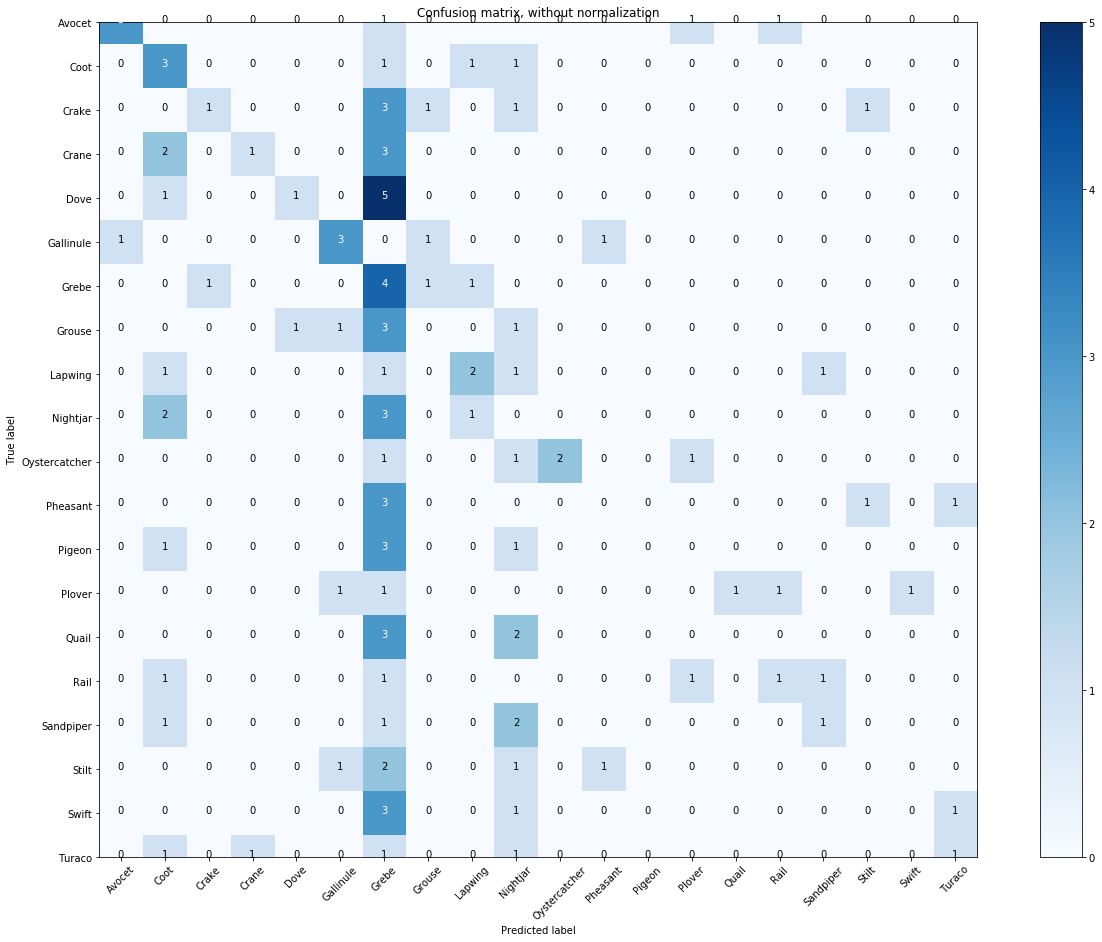

In [43]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [44]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [45]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['Grebe' 'Grouse' 'Dove' 'Avocet' 'Nightjar' 'Crane' 'Lapwing' 'Lapwing'
 'Dove' 'Rail' 'Nightjar' 'Crake' 'Nightjar' 'Quail' 'Lapwing' 'Crane'
 'Grebe' 'Grebe' 'Quail' 'Stilt' 'Pheasant' 'Quail' 'Turaco' 'Turaco'
 'Crane' 'Pheasant' 'Dove' 'Plover' 'Pheasant' 'Pigeon' 'Swift' 'Avocet'
 'Stilt' 'Stilt' 'Coot' 'Swift' 'Grouse' 'Crake' 'Pheasant' 'Pigeon'
 'Grouse' 'Sandpiper' 'Sandpiper' 'Gallinule' 'Sandpiper' 'Oystercatcher'
 'Crake' 'Pheasant' 'Grouse' 'Oystercatcher' 'Grouse' 'Dove' 'Dove'
 'Swift' 'Turaco' 'Crane' 'Plover' 'Plover' 'Gallinule' 'Rail' 'Coot'
 'Nightjar' 'Crake' 'Grouse' 'Turaco' 'Pigeon' 'Crake' 'Nightjar' 'Avocet'
 'Pigeon' 'Plover' 'Quail' 'Swift' 'Plover' 'Lapwing' 'Coot' 'Stilt'
 'Pigeon' 'Rail' 'Stilt' 'Quail' 'Gallinule' 'Crane' 'Swift' 'Rail' 'Dove'
 'Oystercatcher' 'Sandpiper' 'Crake' 'Nightjar']
[ 7  5  1 15  6  6  6  1  6 16  8 17  6  9 16  1  2  8  9  5  6  6  9  1
  1 19  6 18  6  9 19  6  6  9  6  9  4  6 17  6  9  9  1  0  6 13  7  6
  6  6  6  6  6  6

## 4.Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

model_NB = GaussianNB()

In [47]:
model_NB.fit(train_set, train_classes);

## Save / Load Trained Model

In [48]:
# Save
joblib.dump(model_NB, 'trainedNaiveBayes.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

['trainedNaiveBayes.joblib']

In [49]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_NB.predict(test_set)

## Evaluation

In [50]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.67 0.   0.14 0.17 0.14 0.   0.   0.17 0.5  0.17 0.4  0.2  0.   0.
 0.   0.   0.2  0.   0.6  0.  ]
Precision:  [0.4  0.   0.2  0.33 0.25 0.   0.   0.25 0.33 0.25 0.11 0.12 0.   0.
 0.   0.   0.2  0.   0.38 0.  ]
F1-Score:  [0.5  0.   0.17 0.22 0.18 0.   0.   0.2  0.4  0.2  0.17 0.15 0.   0.
 0.   0.   0.2  0.   0.46 0.  ]
Accuracy: 0.17  , 19
Number of samples: 113


In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [52]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

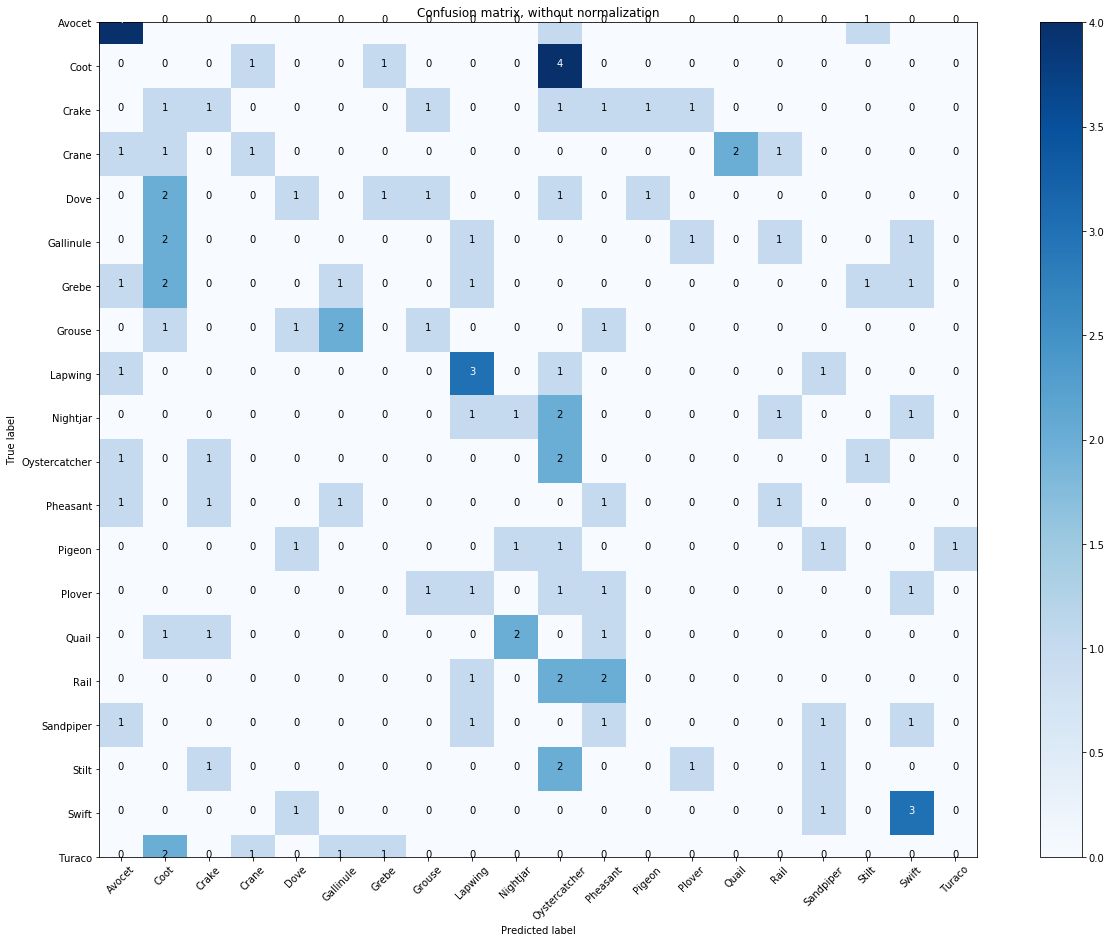

In [53]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [54]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [55]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['Grebe' 'Grouse' 'Dove' 'Sandpiper' 'Avocet' 'Coot' 'Crane' 'Lapwing'
 'Lapwing' 'Dove' 'Rail' 'Nightjar' 'Crake' 'Nightjar' 'Quail' 'Crane'
 'Grebe' 'Grebe' 'Grebe' 'Quail' 'Stilt' 'Pheasant' 'Quail' 'Turaco'
 'Turaco' 'Crane' 'Pheasant' 'Grebe' 'Dove' 'Plover' 'Pheasant' 'Pigeon'
 'Avocet' 'Stilt' 'Stilt' 'Lapwing' 'Gallinule' 'Coot' 'Grebe' 'Grouse'
 'Crake' 'Pheasant' 'Gallinule' 'Pigeon' 'Grouse' 'Sandpiper' 'Gallinule'
 'Sandpiper' 'Gallinule' 'Oystercatcher' 'Grebe' 'Crake' 'Coot'
 'Oystercatcher' 'Grouse' 'Dove' 'Dove' 'Turaco' 'Plover' 'Plover'
 'Gallinule' 'Rail' 'Coot' 'Nightjar' 'Crake' 'Grouse' 'Rail' 'Turaco'
 'Pigeon' 'Crake' 'Oystercatcher' 'Nightjar' 'Pigeon' 'Plover' 'Quail'
 'Swift' 'Plover' 'Coot' 'Turaco' 'Stilt' 'Pigeon' 'Rail' 'Stilt' 'Quail'
 'Gallinule' 'Crane' 'Crane' 'Swift' 'Rail' 'Dove' 'Sandpiper' 'Crake'
 'Coot' 'Nightjar']
[ 1  5 10  8 10 10 14 16 10 12 11  8 11 15  2  0  0 17  8  9 10  5  9  5
  1  1 15 18  1 18  2  9 17  2 13  0  8  6  5  4  7  0  1 1

## 5.Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
model_RFC = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

In [58]:
model_RFC.fit(train_set, train_classes);

## Save / Load Trained Model

In [60]:
# Save
joblib.dump(model_RFC, 'trainedRandomForest.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

['trainedRandomForest.joblib']

In [61]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_RFC.predict(test_set)

## Evaluation

In [62]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [1.   0.67 0.   0.5  0.14 0.   0.14 0.33 0.5  0.33 0.6  0.   0.   0.
 0.   0.   0.   0.   0.4  0.8 ]
Precision:  [0.4  0.17 0.   0.43 0.09 0.   0.5  0.33 0.12 0.29 1.   0.   0.   0.
 0.   0.   0.   0.   0.4  0.5 ]
F1-Score:  [0.57 0.27 0.   0.46 0.11 0.   0.22 0.33 0.2  0.31 0.75 0.   0.   0.
 0.   0.   0.   0.   0.4  0.62]
Accuracy: 0.27  , 31
Number of samples: 113


/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

## 6.Gausian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
model_GMM = GaussianMixture()

In [ ]:
model_GMM.fit(train_set, train_classes);

## Save / Load Trained Model

In [ ]:
# Save
joblib.dump(model_GMM, 'trainedGMM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [1]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_GMM.predict(test_set)

NameError: name 'model_GMM' is not defined

## Evaluation

In [ ]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

## 7.Bayesian Mixture Models

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
model_BGMM = BayesianGaussianMixture()

In [ ]:
model_BGMM.fit(train_set, train_classes);

## Save / Load Trained Model

In [ ]:
# Save
joblib.dump(model_BGMM, 'trainedBGMM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [ ]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_BGMM.predict(test_set)

## Evaluation

In [ ]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])